In [1]:
###AUTHORS###
# SHASHANK KATHAVATE
# SSK210005
# GAURAV PATIL
# GVP190001

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
import torch
import warnings
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.nn import *
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
from torch.optim import Adam
from torch.utils.data import DataLoader
warnings.filterwarnings("ignore")


In [3]:
trainSet = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testSet = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


In [4]:
learningRate = 0.05
batchSize = 128
numWorkers = 1

idx = list(range(len(trainSet)))
np.random.shuffle(idx)
spt = int(np.floor(0.1 * len(trainSet)))
trainSamp = SubsetRandomSampler(idx[:spt])
validSamp = SubsetRandomSampler(idx[spt:])

trainLoader = DataLoader(dataset=trainSet, batch_size=batchSize,num_workers=numWorkers,sampler=trainSamp)
validationLoader = DataLoader(dataset=trainSet, batch_size=batchSize,num_workers=numWorkers,sampler=validSamp)
testLoader = DataLoader(dataset=testSet, batch_size=batchSize,num_workers=numWorkers)

xTrainSet, yTrainSet = next(iter(trainLoader))
xValidationSet, yValidationSet = next(iter(validationLoader))
print(xTrainSet.reshape(-1,28,28).shape)

torch.Size([128, 28, 28])


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x17e568400>)

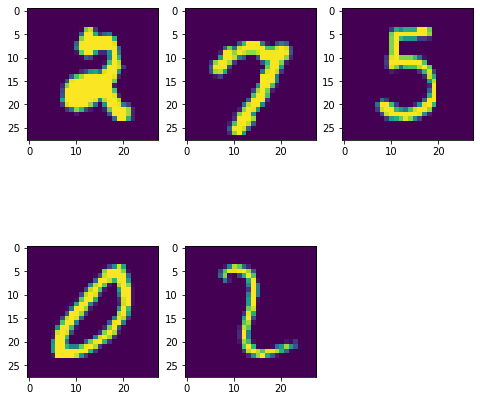

In [5]:
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTrainSet.reshape(-1,28,28)[10])
plt.subplot(232), plt.imshow(xTrainSet.reshape(-1,28,28)[20])
plt.subplot(233), plt.imshow(xTrainSet.reshape(-1,28,28)[30])
plt.subplot(234), plt.imshow(xTrainSet.reshape(-1,28,28)[40])
plt.subplot(235), plt.imshow(xTrainSet.reshape(-1,28,28)[50])

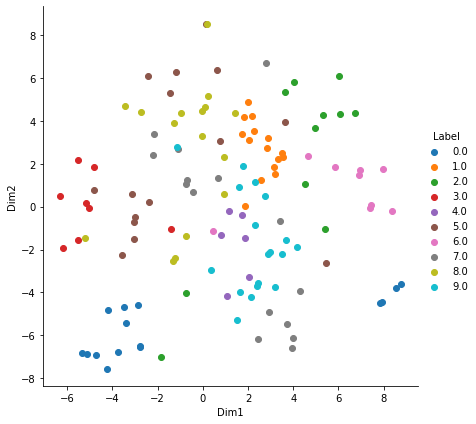

In [6]:
#Exploratory data analysis using TSNE
trainS = StandardScaler().fit_transform(xTrainSet.reshape(-1,784))
x1000 = trainS[:batchSize,:]
y1000 = yTrainSet[:batchSize]
model = TSNE(n_components=2,random_state=0)
tData = model.fit_transform(x1000)
tData = np.vstack((tData.T,y1000.T)).T
tDataDf = pd.DataFrame(data=tData,columns= ["Dim1","Dim2","Label"])
sns.FacetGrid(tDataDf,hue="Label",size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

In [7]:
class LeNet5(Module):

    def __init__(self):
        super().__init__()

        self.layer1 = Sequential(
            Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            BatchNorm2d(6),
            Tanh(),
            MaxPool2d(kernel_size = 2, stride = 2),
            Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            BatchNorm2d(16),
            Tanh(),
            MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = Linear(256, 120)
        self.tanh = Tanh()
        self.fc1 = Linear(120, 84)
        self.tanh1 = Tanh()
        self.fc2 = Linear(84, 10)
        self.softmax = Softmax(dim=1)
    def forward(self,x):
        x = self.layer1(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = self.tanh(x)
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [8]:
model = LeNet5()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
lossFunc = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    lossFunc = lossFunc.cuda()
    
print(model)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=120, bias=True)
  (tanh): Tanh()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (tanh1): Tanh()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [9]:
trainLossList = []
validationLossList = []

def trainData(epoch):
    model.train()
    trainLossSum = 0
    validationLossSum = 0
    for trainImages,trainLabels in trainLoader:
        trainImages,trainLabels = Variable(trainImages), Variable(trainLabels)
        if torch.cuda.is_available():
            trainImages = trainImages.cuda()
            trainLabels = trainLabels.cuda()

        yPredTrain = model(trainImages)
        optimizer.zero_grad()
        trainLoss = lossFunc(yPredTrain,trainLabels)
        trainLoss.backward()
        optimizer.step()
        trainLossSum += trainLoss.item()*trainImages.size(0)
    
    for validationImages, validationLabels in validationLoader:
        validationImages,validationLabels = Variable(validationImages), Variable(validationLabels)
        if torch.cuda.is_available():
            validationImages = validationImages.cuda()
            validationLabels = validationLabels.cuda()
        
        yPredValidation = model(validationImages)
        validationLoss = lossFunc(yPredValidation,validationLabels)
        validationLossSum += validationLoss.item()*validationImages.size(0)
    
    trainLossSum = trainLossSum/len(trainLoader.sampler)
    validationLossSum = validationLossSum/len(validationLoader.sampler)
    trainLossList.append(trainLossSum)
    validationLossList.append(validationLossSum)
    if epoch%2 == 0:
        print('Epoch: ',epoch+1,'\t','loss: ',trainLossSum)



In [10]:
totalEpochs = 10

for epoch in range(totalEpochs):
    trainData(epoch)


Epoch:  1 	 loss:  2.092984540939331
Epoch:  3 	 loss:  1.8814252144495647
Epoch:  5 	 loss:  1.8214080152511596
Epoch:  7 	 loss:  1.7559788179397584
Epoch:  9 	 loss:  1.7515600423812867


<function matplotlib.pyplot.show(close=None, block=None)>

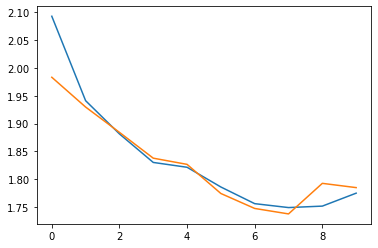

In [11]:
#plotting the losses
plt.plot(trainLossList,label = 'Training')
plt.plot(validationLossList,label='Validation')
plt.show

In [12]:
#Accuracy
def calcAccuracy(loader):
    totalLoss = 0
    correctClass = [0,0,0,0,0,0,0,0,0,0]
    totalClassCount = [0,0,0,0,0,0,0,0,0,0]
    for images,labels in loader:
        if torch.cuda.is_available():
            yTrainPred = model(images.cuda())
            labels = labels.cuda()
        else:
            yTrainPred = model(images)
        
        lossCalc = lossFunc(yTrainPred,labels)
        totalLoss += lossCalc.item()*images.size(0)

        blank, prediction = torch.max(yTrainPred,1)
        trueLabelPred = np.squeeze(prediction.eq(labels.data.view_as(prediction)))

        for ix in range(len(labels)):
            lb = labels.data[ix]
            correctClass[lb] += trueLabelPred[ix].item()
            totalClassCount[lb] += 1

    accuracy = np.sum(correctClass) / np.sum(totalClassCount)
    return accuracy


trainAccuracy = calcAccuracy(trainLoader)
validationAccuracy = calcAccuracy(validationLoader)

print("Train Accuracy= ",trainAccuracy)
print("Validation Accuracy= ",validationAccuracy)

Train Accuracy=  0.6895
Validation Accuracy=  0.6752777777777778


['Seven', 'Two', 'One', 'Zero', 'Four']


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x16e3daf50>)

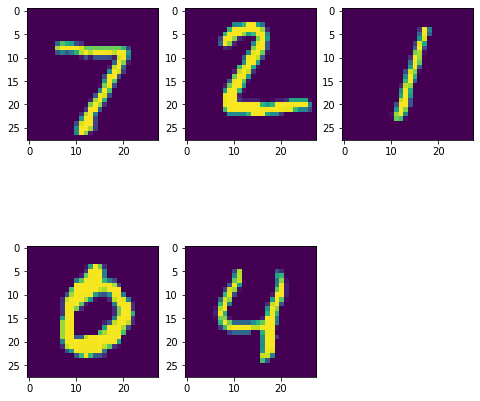

In [13]:
#Test set predicitons
xTestSet, yTestSet = next(iter(testLoader))

if torch.cuda.is_available():
    with torch.no_grad():
        yTestPred = model(xTestSet.cuda())
        softmax = torch.exp(yTestPred).cpu()
else:
    yTestPred = model(xTestSet)
    softmax = torch.exp(yTestPred.detach())
    
probability = list(softmax.numpy())
predictions = np.argmax(probability, axis=1)
labelDict = {
    0:"Zero",
    1:"One",
    2:"Two",
    3:"Three",
    4:"Four",
    5:"Five",
    6:"Six",
    7:"Seven",
    8:"Eight",
    9:"Nine"
}
#Results for the 10000 test data images. The above dictionary represents the classification label for the data.
predictions = [labelDict[i] for i in predictions]
#First 5 Predictions
print(predictions[:5])
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTestSet.reshape(-1,28,28)[0])
plt.subplot(232), plt.imshow(xTestSet.reshape(-1,28,28)[1])
plt.subplot(233), plt.imshow(xTestSet.reshape(-1,28,28)[2])
plt.subplot(234), plt.imshow(xTestSet.reshape(-1,28,28)[3])
plt.subplot(235), plt.imshow(xTestSet.reshape(-1,28,28)[4])